# Ungraded Lab: Predicting Sunspots with Neural Networks (DNN only)

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week4/Labs/C4_W4_Lab_2_Sunspots_DNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In the remaining labs for this week, you will move away from synthetic time series and start building models for real world data. In particular, you will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. You will first build a deep neural network here composed of dense layers. This will act as your baseline so you can compare it to the next lab where you will use a more complex architecture.

Let's begin!

## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
from keras import Sequential, Input, layers, optimizers, losses, callbacks, backend, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

2024-06-14 14:07:00.748749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    sns.set_style("whitegrid")

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
        for y_curr in y:
            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-06-14 14:07:02--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4012:822::201b, 2607:f8b0:4012:823::201b, 2607:f8b0:4012:824::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4012:822::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.07s   

2024-06-14 14:07:03 (988 KB/s) - ‘Sunspots.csv’ saved [70827/70827]



Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


For this lab and the next, you will only need the month number and the mean total sunspot number. You will load those into memory and convert it to arrays that represents a time series.

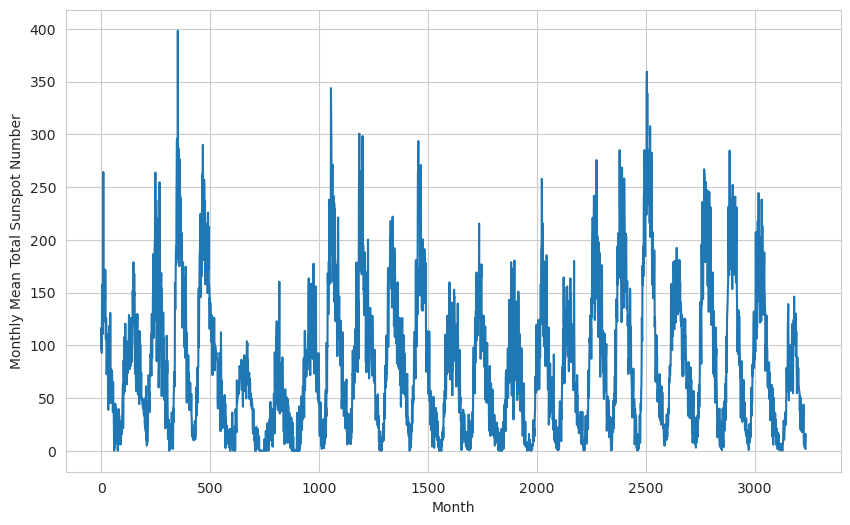

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3235 points in the dataset and you will use the first 3000 for training.

In [6]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-14 14:07:03.974585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1870 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Build the Model

The model will be 3-layer dense network as shown below.

In [9]:
# Build the model
model = Sequential([Input(shape=(window_size,)),
                    layers.Dense(30, activation="relu"),
                    layers.Dense(10, activation="relu"),
                    layers.Dense(1)])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [10]:
# Set the learning rate scheduler
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


I0000 00:00:1718395624.548077   75871 service.cc:145] XLA service 0x7f11140028b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718395624.548111   75871 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-14 14:07:04.560904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 14:07:04.612057: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


     81/Unknown 1s 1ms/step - loss: 60.8518 

I0000 00:00:1718395625.037376   75871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 61.3175 - learning_rate: 1.0000e-08
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.4572 - learning_rate: 1.1220e-08
Epoch 3/100


2024-06-14 14:07:05.544702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:05.544745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:05.544754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:05.544766: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your datas

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.9167 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.0356 - learning_rate: 1.4125e-08
Epoch 5/100


2024-06-14 14:07:05.883198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:05.883225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:05.883235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:05.883246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:06.052778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:06.052801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.2693 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.0548 - learning_rate: 1.7783e-08
Epoch 7/100


2024-06-14 14:07:06.214886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:06.214910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:06.214920: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:06.214931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:06.374975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:06.375009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.6208 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.1937 - learning_rate: 2.2387e-08
Epoch 9/100


2024-06-14 14:07:06.541782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:06.541805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:06.541821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:06.705868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:06.705894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:06.705902: I tensorflow/core/framework/local_ren

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.8203 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.3425 - learning_rate: 2.8184e-08
Epoch 11/100


2024-06-14 14:07:06.932280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:06.932304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:06.932312: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:06.932320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:07.101857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:07.101903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53.0601 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51.5324 - learning_rate: 3.5481e-08
Epoch 13/100


2024-06-14 14:07:07.257276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:07.257302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:07.257312: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:07.257323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:07.419806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:07.419831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50.6080 - learning_rate: 3.9811e-08
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51.3321 - learning_rate: 4.4668e-08
Epoch 15/100


2024-06-14 14:07:07.583101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:07.583125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:07.583133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:07.583140: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:07.744368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:07.744393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51.3841 - learning_rate: 5.0119e-08
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.7959 - learning_rate: 5.6234e-08
Epoch 17/100


2024-06-14 14:07:07.908769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:07.908794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:07.908802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:07.908809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:08.068090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:08.068114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.4655 - learning_rate: 6.3096e-08
Epoch 18/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.9348 - learning_rate: 7.0795e-08
Epoch 19/100


2024-06-14 14:07:08.246319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:08.246342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:08.246350: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:08.246359: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:08.432720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:08.432744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.5323 - learning_rate: 7.9433e-08
Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.3614 - learning_rate: 8.9125e-08
Epoch 21/100


2024-06-14 14:07:08.602580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:08.602605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:08.602615: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:08.602625: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:08.772392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:08.772417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.2870 - learning_rate: 1.0000e-07
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.3275 - learning_rate: 1.1220e-07
Epoch 23/100


2024-06-14 14:07:08.995702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:08.995724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:08.995732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:08.995740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:09.161280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:09.161307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.9282 - learning_rate: 1.2589e-07
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.1110 - learning_rate: 1.4125e-07
Epoch 25/100


2024-06-14 14:07:09.329094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:09.329120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:09.329128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:09.329136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:09.492185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:09.492208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.1014 - learning_rate: 1.5849e-07
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.7673 - learning_rate: 1.7783e-07
Epoch 27/100


2024-06-14 14:07:09.670165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:09.670191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:09.670201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:09.670212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:09.835115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:09.835137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.8956 - learning_rate: 1.9953e-07
Epoch 28/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.6528 - learning_rate: 2.2387e-07
Epoch 29/100


2024-06-14 14:07:10.001756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.001780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:10.001787: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:10.001795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:10.168140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.168164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.0023 - learning_rate: 2.5119e-07
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.3248 - learning_rate: 2.8184e-07
Epoch 31/100


2024-06-14 14:07:10.333726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.333749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:10.333764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:10.493556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.493581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:10.493589: I tensorflow/core/framework/local_ren

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.0635 - learning_rate: 3.1623e-07
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34.1118 - learning_rate: 3.5481e-07
Epoch 33/100


2024-06-14 14:07:10.655300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.655323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:10.655331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:10.655338: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:10.821647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.821670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33.4540 - learning_rate: 3.9811e-07
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.8580 - learning_rate: 4.4668e-07
Epoch 35/100


2024-06-14 14:07:10.986227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:10.986253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:10.986263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:10.986276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:11.155064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:11.155087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.3009 - learning_rate: 5.0119e-07
Epoch 36/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.0177 - learning_rate: 5.6234e-07
Epoch 37/100


2024-06-14 14:07:11.367519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:11.367543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:11.367552: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:11.367559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:11.549222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:11.549246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.5428 - learning_rate: 6.3096e-07
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28.2895 - learning_rate: 7.0795e-07
Epoch 39/100


2024-06-14 14:07:11.702656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:11.702679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:11.702689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:11.702701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:11.874167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:11.874194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.3249 - learning_rate: 7.9433e-07
Epoch 40/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27.1063 - learning_rate: 8.9125e-07
Epoch 41/100


2024-06-14 14:07:12.046462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:12.046488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:12.046496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:12.046504: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:12.217426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:12.217460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26.0993 - learning_rate: 1.0000e-06
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25.5014 - learning_rate: 1.1220e-06
Epoch 43/100


2024-06-14 14:07:12.381737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 14:07:12.381759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:12.545461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:12.545483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:12.545491: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:12.545499: I tensorflow/core/framework/local_ren

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.6173 - learning_rate: 1.2589e-06
Epoch 44/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.3648 - learning_rate: 1.4125e-06
Epoch 45/100


2024-06-14 14:07:12.719508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:12.719532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:12.719539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:12.719547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:12.884271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:12.884299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.7216 - learning_rate: 1.5849e-06
Epoch 46/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - loss: 25.3688

2024-06-14 14:07:13.058138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:13.058162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:13.058173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:13.058183: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.7229 - learning_rate: 1.7783e-06
Epoch 47/100
43/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.0317

2024-06-14 14:07:13.367584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:13.367610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:13.367618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:13.367627: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.2092 - learning_rate: 1.9953e-06
Epoch 48/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.4535 - learning_rate: 2.2387e-06
Epoch 49/100


2024-06-14 14:07:13.598164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:13.598186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:13.598195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:13.598203: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:13.766527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:13.766561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.6273 - learning_rate: 2.5119e-06
Epoch 50/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.7347 - learning_rate: 2.8184e-06
Epoch 51/100


2024-06-14 14:07:13.941834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:13.941859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:13.941868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:13.941875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:14.116632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:14.116657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.7732 - learning_rate: 3.1623e-06
Epoch 52/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.2958 - learning_rate: 3.5481e-06
Epoch 53/100


2024-06-14 14:07:14.281200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:14.281225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:14.281232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:14.281240: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:14.444710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:14.444737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2991 - learning_rate: 3.9811e-06
Epoch 54/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.2362 - learning_rate: 4.4668e-06
Epoch 55/100


2024-06-14 14:07:14.620902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:14.620926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:14.620937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:14.620948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:14.790108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:14.790142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.0887 - learning_rate: 5.0119e-06
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5777 - learning_rate: 5.6234e-06
Epoch 57/100


2024-06-14 14:07:14.963631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:14.963656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:14.963664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:14.963672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:15.124242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:15.124268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5938 - learning_rate: 6.3096e-06
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.5278 - learning_rate: 7.0795e-06
Epoch 59/100


2024-06-14 14:07:15.292543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:15.292569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:15.292577: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:15.292584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:15.459269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:15.459294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3292 - learning_rate: 7.9433e-06
Epoch 60/100
28/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3785

2024-06-14 14:07:15.628896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:15.628920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:15.628928: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:15.628936: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2448 - learning_rate: 8.9125e-06
Epoch 61/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0526 - learning_rate: 1.0000e-05
Epoch 62/100


2024-06-14 14:07:15.861121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:15.861145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:15.861155: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:15.861164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:16.048534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:16.048565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7593 - learning_rate: 1.1220e-05
Epoch 63/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1376 - learning_rate: 1.2589e-05
Epoch 64/100


2024-06-14 14:07:16.217019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:16.217050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:16.217059: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:16.217068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:16.386787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:16.386811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6521 - learning_rate: 1.4125e-05
Epoch 65/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0762 - learning_rate: 1.5849e-05
Epoch 66/100


2024-06-14 14:07:16.561485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:16.561507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:16.561516: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:16.561524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:16.728182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:16.728203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6892 - learning_rate: 1.7783e-05
Epoch 67/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5473 - learning_rate: 1.9953e-05
Epoch 68/100


2024-06-14 14:07:16.890743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:16.890772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:16.890783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:16.890794: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:17.056552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:17.056578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1722 - learning_rate: 2.2387e-05
Epoch 69/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.3629 - learning_rate: 2.5119e-05
Epoch 70/100


2024-06-14 14:07:17.224474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:17.224495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:17.224506: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:17.224516: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:17.388291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:17.388318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2548 - learning_rate: 2.8184e-05
Epoch 71/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5656 - learning_rate: 3.1623e-05
Epoch 72/100


2024-06-14 14:07:17.557902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:17.557925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:17.557936: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:17.557947: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:17.730054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:17.730080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5485 - learning_rate: 3.5481e-05
Epoch 73/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4830

2024-06-14 14:07:17.889527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:17.889551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:17.889559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:17.889567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.7278 - learning_rate: 3.9811e-05
Epoch 74/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1362 - learning_rate: 4.4668e-05
Epoch 75/100


2024-06-14 14:07:18.109953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:18.109975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:18.109983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:18.109991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:18.282449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:18.282471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9364 - learning_rate: 5.0119e-05
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5980 - learning_rate: 5.6234e-05
Epoch 77/100


2024-06-14 14:07:18.460747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:18.460775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:18.460785: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:18.460795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:18.633908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:18.633933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9983 - learning_rate: 6.3096e-05
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.1225 - learning_rate: 7.0795e-05
Epoch 79/100


2024-06-14 14:07:18.825554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:18.825573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:18.825582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:18.825590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:18.986280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:18.986302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5845 - learning_rate: 7.9433e-05
Epoch 80/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0529 - learning_rate: 8.9125e-05
Epoch 81/100


2024-06-14 14:07:19.155108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:19.155133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:19.155140: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:19.155148: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:19.326007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:19.326038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.7274 - learning_rate: 1.0000e-04
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.7081 - learning_rate: 1.1220e-04
Epoch 83/100


2024-06-14 14:07:19.493484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:19.493508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:19.493523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:19.671835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:19.671858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:19.671867: I tensorflow/core/framework/local_ren

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5225 - learning_rate: 1.2589e-04
Epoch 84/100
35/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0279  

2024-06-14 14:07:19.852337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:19.852362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:19.852370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:19.852377: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1601 - learning_rate: 1.4125e-04
Epoch 85/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0016 - learning_rate: 1.5849e-04
Epoch 86/100


2024-06-14 14:07:20.080104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:20.080130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:20.080140: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:20.080149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:20.269311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:20.269340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3210 - learning_rate: 1.7783e-04
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.0731 - learning_rate: 1.9953e-04


2024-06-14 14:07:20.466281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:20.466309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:20.466318: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:20.466327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:20.662431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:20.662462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2515 - learning_rate: 2.2387e-04
Epoch 89/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9787

2024-06-14 14:07:20.864316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:20.864344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:20.864353: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:20.864362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4607 - learning_rate: 2.5119e-04
Epoch 90/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1010

2024-06-14 14:07:21.072423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:21.072449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:21.072458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:21.072468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.1398 - learning_rate: 2.8184e-04
Epoch 91/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.6291 - learning_rate: 3.1623e-04
Epoch 92/100


2024-06-14 14:07:21.280043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:21.280071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:21.280080: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:21.280089: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:21.474951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:21.474985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.6349 - learning_rate: 3.5481e-04
Epoch 93/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6445

2024-06-14 14:07:21.677393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:21.677417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:21.677426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:21.677435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0599 - learning_rate: 3.9811e-04
Epoch 94/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7845

2024-06-14 14:07:21.886031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:21.886057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:21.886066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:21.886075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5678 - learning_rate: 4.4668e-04
Epoch 95/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.4233 - learning_rate: 5.0119e-04
Epoch 96/100


2024-06-14 14:07:22.094553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:22.094581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:22.094590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:22.094599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:22.291170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:22.291195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.4847 - learning_rate: 5.6234e-04
Epoch 97/100
52/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.3214

2024-06-14 14:07:22.568372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:22.568406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:22.568417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:22.568428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9310 - learning_rate: 6.3096e-04
Epoch 98/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.2540

2024-06-14 14:07:22.800504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:22.800533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:22.800543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:22.800552: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.1410 - learning_rate: 7.0795e-04
Epoch 99/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.7805

2024-06-14 14:07:23.004986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:23.005019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:23.005029: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:23.005039: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.0758 - learning_rate: 7.9433e-04
Epoch 100/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.2574

2024-06-14 14:07:23.217377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:23.217407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:23.217417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:23.217428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.4286 - learning_rate: 8.9125e-04


2024-06-14 14:07:23.434546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:23.434574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:23.434583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:23.434593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


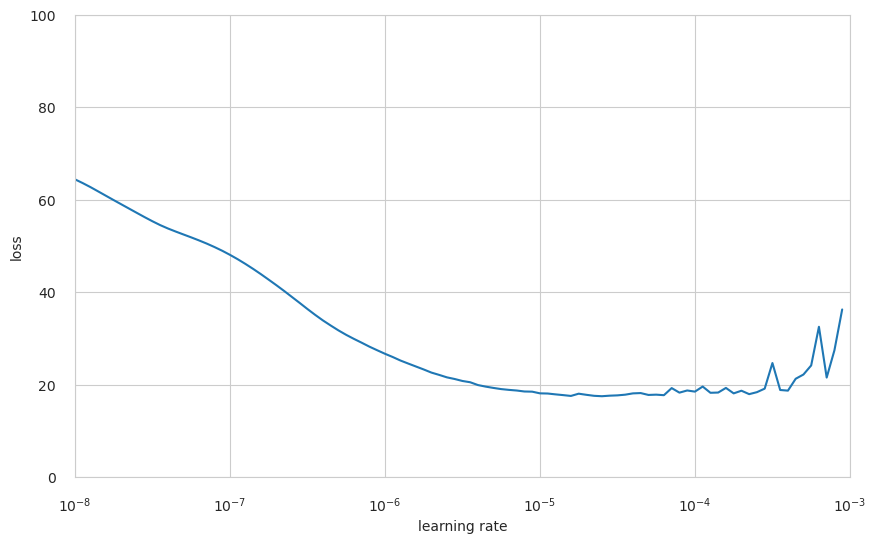

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [12]:
# Reset states generated by Keras
backend.clear_session()

# Build the Model
model = Sequential([Input(shape=(window_size,)),
                    layers.Dense(30, activation="relu"),
                    layers.Dense(10, activation="relu"),
                    layers.Dense(1)])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32.9914 - mae: 33.4866
Epoch 2/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0272 - mae: 19.5204

2024-06-14 14:07:25.115273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:25.115305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:25.115315: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:25.115326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.0853 - mae: 19.5788
Epoch 3/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2214 - mae: 18.7102   

2024-06-14 14:07:25.320470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:25.320499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:25.320508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:25.320518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.5330 - mae: 19.0251
Epoch 4/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2500 - mae: 18.7437

2024-06-14 14:07:25.577468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:25.577499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:25.577512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:25.577522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3703 - mae: 18.8638
Epoch 5/100
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2331 - mae: 18.7273

2024-06-14 14:07:25.792270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:25.792296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:25.792305: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:25.792315: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.2268 - mae: 18.7210
Epoch 6/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.5339 - mae: 18.0275

2024-06-14 14:07:26.001938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:26.001968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:26.001981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:26.001994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6658 - mae: 18.1597
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6686 - mae: 18.1608


2024-06-14 14:07:26.205174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:26.205203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:26.205212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:26.205223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:26.402817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:26.402844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1559 - mae: 18.6494
Epoch 9/100
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.8989 - mae: 18.3922

2024-06-14 14:07:26.606115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:26.606142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:26.606152: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:26.606163: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:26.805476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:26.805503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7676 - mae: 18.2609
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6706 - mae: 18.1647
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1992 - mae: 17.6922
Epoch 12/100


2024-06-14 14:07:27.004968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:27.004997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:27.005007: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:27.005016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:27.198924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:27.198950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6790 - mae: 18.1715
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8827 - mae: 17.3764
Epoch 14/100


2024-06-14 14:07:27.394511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:27.394537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:27.394546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:27.394555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:27.591657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:27.591682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.6739 - mae: 18.1652
Epoch 15/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - loss: 19.7239 - mae: 20.2103

2024-06-14 14:07:27.791893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:27.791921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:27.791930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:27.791943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2315 - mae: 17.7240
Epoch 16/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0882 - mae: 18.5840

2024-06-14 14:07:28.142522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:28.142546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:28.142555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:28.142564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.7963 - mae: 18.2910
Epoch 17/100
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9629 - mae: 17.4551

2024-06-14 14:07:28.352777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:28.352811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:28.352823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:28.352836: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1152 - mae: 17.6074
Epoch 18/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4408 - mae: 17.9333

2024-06-14 14:07:28.561638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:28.561672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:28.561686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:28.561700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3688 - mae: 17.8611
Epoch 19/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2219 - mae: 17.7146


2024-06-14 14:07:28.768229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:28.768259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:28.768268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:28.768278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:28.966909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:28.966937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 20/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8941 - mae: 17.3862
Epoch 21/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2762 - mae: 17.7689
Epoch 22/100


2024-06-14 14:07:29.162739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:29.162768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:29.162777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:29.162786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:29.356948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:29.356973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2735 - mae: 17.7653
Epoch 23/100
40/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.2524 - mae: 16.7409

2024-06-14 14:07:29.557920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:29.557946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:29.557955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:29.557964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7180 - mae: 17.2076
Epoch 24/100
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0714 - mae: 18.5647

2024-06-14 14:07:29.802790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:29.802819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:29.802828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:29.802838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6936 - mae: 18.1867
Epoch 25/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4564 - mae: 17.9499

2024-06-14 14:07:30.027540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:30.027571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:30.027585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:30.027603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4789 - mae: 17.9717
Epoch 26/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1990 - mae: 17.6887

2024-06-14 14:07:30.238483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:30.238510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:30.238520: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:30.238530: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1889 - mae: 17.6797
Epoch 27/100
27/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8779 - mae: 17.3691   

2024-06-14 14:07:30.451661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:30.451688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:30.451697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:30.451706: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9593 - mae: 17.4517
Epoch 28/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0014 - mae: 17.4903

2024-06-14 14:07:30.723569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:30.723597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:30.723611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:30.723625: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0769 - mae: 17.5667
Epoch 29/100
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9699 - mae: 17.4621

2024-06-14 14:07:30.936680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:30.936712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 14:07:31.135493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:31.135533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:31.135542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:31.135554: I tensorflow/core/framework/local_ren

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9988 - mae: 17.4904
Epoch 30/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6704 - mae: 17.1614
Epoch 31/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8579 - mae: 17.3500

2024-06-14 14:07:31.349907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:31.349935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:31.349947: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:31.349959: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9258 - mae: 17.4174
Epoch 32/100
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7381 - mae: 17.2304

2024-06-14 14:07:31.575441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:31.575482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:31.575517: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:31.575536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9168 - mae: 17.4087
Epoch 33/100
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6864 - mae: 17.1763

2024-06-14 14:07:31.818094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:31.818122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:31.818132: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:31.818142: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7123 - mae: 17.2026
Epoch 34/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9679 - mae: 17.4561

2024-06-14 14:07:32.043765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:32.043791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:32.043811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9280 - mae: 17.4167
Epoch 35/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2403 - mae: 17.7293

2024-06-14 14:07:32.253023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:32.253051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:32.253063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:32.253076: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1165 - mae: 17.6063
Epoch 36/100
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7346 - mae: 17.2267

2024-06-14 14:07:32.464069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:32.464099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:32.464109: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:32.464119: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7148 - mae: 17.2062
Epoch 37/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9424 - mae: 17.4349
Epoch 38/100


2024-06-14 14:07:32.668170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:32.668199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:32.668209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:32.668219: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:32.859969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:32.859997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2879 - mae: 17.7787
Epoch 39/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9285 - mae: 17.4212
Epoch 40/100


2024-06-14 14:07:33.058562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:33.058589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:33.058599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:33.058609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:33.248803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:33.248833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.1626 - mae: 16.6545
Epoch 41/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5151 - mae: 17.0073

2024-06-14 14:07:33.514844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:33.514873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:33.514887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:33.514902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6872 - mae: 17.1796
Epoch 42/100
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2372 - mae: 16.7295

2024-06-14 14:07:33.732772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:33.732809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:33.732823: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:33.732838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5672 - mae: 17.0592
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8645 - mae: 17.3564
Epoch 44/100


2024-06-14 14:07:33.934249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:33.934276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:33.934286: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:33.934295: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:34.126035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:34.126061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1621 - mae: 17.6549
Epoch 45/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5340 - mae: 17.0254
Epoch 46/100


2024-06-14 14:07:34.321917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:34.321943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:34.321952: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:34.321961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:34.516774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:34.516802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9496 - mae: 17.4405
Epoch 47/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8541 - mae: 17.3454
Epoch 48/100


2024-06-14 14:07:34.709394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:34.709419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:34.709427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:34.709436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:34.906515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:34.906539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.2084 - mae: 17.6991
Epoch 49/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9609 - mae: 17.4545

2024-06-14 14:07:35.105951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:35.105981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:35.105993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:35.106006: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8681 - mae: 17.3605
Epoch 50/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2530 - mae: 16.7436

2024-06-14 14:07:35.311569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:35.311595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:35.311607: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:35.311620: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4831 - mae: 16.9738
Epoch 51/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5290 - mae: 17.0201

2024-06-14 14:07:35.513589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:35.513612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:35.513621: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:35.513631: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7195 - mae: 17.2106
Epoch 52/100
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3427 - mae: 17.8344

2024-06-14 14:07:35.720319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:35.720349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:35.720363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:35.720378: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2430 - mae: 17.7348
Epoch 53/100
29/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8440 - mae: 17.3345   

2024-06-14 14:07:35.941325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:35.941351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:35.941360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:35.941369: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9053 - mae: 17.3958
Epoch 54/100
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7783 - mae: 17.2691

2024-06-14 14:07:36.204966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:36.204993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:36.205002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:36.205012: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:36.403323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:36.403350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7975 - mae: 17.2878
Epoch 55/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7563 - mae: 17.2492
Epoch 56/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4210 - mae: 16.9123
Epoch 57/100


2024-06-14 14:07:36.595308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:36.595333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:36.595342: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:36.595350: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:36.776347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:36.776375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2320 - mae: 16.7232
Epoch 58/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0256 - mae: 17.5180
Epoch 59/100


2024-06-14 14:07:36.963470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:36.963500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:36.963512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:36.963521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:37.145750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:37.145776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6825 - mae: 17.1744
Epoch 60/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8710 - mae: 17.3616
Epoch 61/100


2024-06-14 14:07:37.334669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:37.334695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:37.334704: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:37.334712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:37.525197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:37.525225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0030 - mae: 17.4946
Epoch 62/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9187 - mae: 17.4101
Epoch 63/100


2024-06-14 14:07:37.715419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:37.715453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:37.715465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:37.715478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:37.904058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:37.904087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4979 - mae: 17.9917
Epoch 64/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6191 - mae: 17.1091
Epoch 65/100


2024-06-14 14:07:38.092397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:38.092421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:38.092430: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:38.092439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:38.288269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:38.288294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7617 - mae: 17.2525 
Epoch 66/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.9562 - mae: 17.4463
Epoch 67/100


2024-06-14 14:07:38.536999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:38.537025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:38.537034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:38.537043: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:38.730118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:38.730144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.0600 - mae: 17.5530
Epoch 68/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5957 - mae: 17.0875
Epoch 69/100


2024-06-14 14:07:38.916936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:38.916965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:38.916977: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:38.916989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:39.101126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:39.101153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6499 - mae: 17.1397
Epoch 70/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7215 - mae: 17.2129


2024-06-14 14:07:39.295440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:39.295466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:39.295475: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:39.295484: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:39.492217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:39.492242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 71/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7585 - mae: 17.2486
Epoch 72/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4986 - mae: 16.9908
Epoch 73/100


2024-06-14 14:07:39.682805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:39.682832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:39.682842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:39.682851: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:39.869729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:39.869753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4386 - mae: 17.9297
Epoch 74/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7104 - mae: 17.2014
Epoch 75/100


2024-06-14 14:07:40.060327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:40.060359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:40.060372: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:40.060381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:40.248973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:40.248998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.3360 - mae: 16.8276
Epoch 76/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.5506 - mae: 18.0426
Epoch 77/100


2024-06-14 14:07:40.442156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:40.442182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:40.442190: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:40.442199: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:40.626827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:40.626851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6211 - mae: 17.1128
Epoch 78/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.8868 - mae: 17.3789
Epoch 79/100


2024-06-14 14:07:40.874442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:40.874472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:40.874482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:40.874491: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:41.067280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:41.067305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.1387 - mae: 16.6271
Epoch 80/100
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.7671 - mae: 16.2583

2024-06-14 14:07:41.281977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:41.282005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:41.282014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:41.282024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:41.481935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:41.481966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1603 - mae: 16.6513
Epoch 81/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6490 - mae: 17.1415
Epoch 82/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2598 - mae: 16.7505
Epoch 83/100


2024-06-14 14:07:41.673895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:41.673925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:41.673935: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:41.673944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:41.869373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:41.869404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4469 - mae: 16.9366
Epoch 84/100
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1733 - mae: 17.6650

2024-06-14 14:07:42.062072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:42.062108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:42.062122: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:42.062136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:42.261027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:42.261053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.1148 - mae: 17.6060
Epoch 85/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6428 - mae: 17.1343
Epoch 86/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8654 - mae: 17.3558

2024-06-14 14:07:42.457439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:42.457467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:42.457476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:42.457485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7794 - mae: 17.2699
Epoch 87/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7490 - mae: 17.2401


2024-06-14 14:07:42.661841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:42.661872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:42.661882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:42.661891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:42.859806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:42.859831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

Epoch 88/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.4112 - mae: 16.9030
Epoch 89/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.7428 - mae: 17.2358
Epoch 90/100


2024-06-14 14:07:43.056093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:43.056116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:43.056125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:43.056134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:43.250569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:43.250593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2954 - mae: 16.7849
Epoch 91/100
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.8702 - mae: 16.3628

2024-06-14 14:07:43.523051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:43.523076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:43.523086: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:43.523095: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2991 - mae: 16.7916
Epoch 92/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6695 - mae: 17.1602

2024-06-14 14:07:43.755589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:43.755615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:43.755623: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:43.755633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7189 - mae: 17.2095
Epoch 93/100
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3451 - mae: 16.8369

2024-06-14 14:07:43.960295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:43.960326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:43.960335: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:43.960349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4744 - mae: 16.9661
Epoch 94/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6325 - mae: 17.1225

2024-06-14 14:07:44.175735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:44.175764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:44.175774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:44.175786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6111 - mae: 17.1006
Epoch 95/100
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5666 - mae: 17.0592

2024-06-14 14:07:44.386744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:44.386770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:44.386779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:44.386788: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6639 - mae: 17.1557
Epoch 96/100
57/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8377 - mae: 17.3268

2024-06-14 14:07:44.602863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:44.602892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8114 - mae: 17.3010
Epoch 97/100
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.1248 - mae: 16.6155

2024-06-14 14:07:44.806557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:44.806585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:44.806595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:44.806604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:45.008267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:45.008291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2334 - mae: 16.7239
Epoch 98/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6122 - mae: 17.1023
Epoch 99/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6978 - mae: 17.1887
Epoch 100/100


2024-06-14 14:07:45.248349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:45.248386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:45.248398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:45.248412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648
2024-06-14 14:07:45.443484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:45.443519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.5962 - mae: 17.0882


2024-06-14 14:07:45.639409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 14:07:45.639433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 14:07:45.639442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5335255536984478319
2024-06-14 14:07:45.639450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6124035153613285648


## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15.

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2024-06-14 14:07:46.035757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


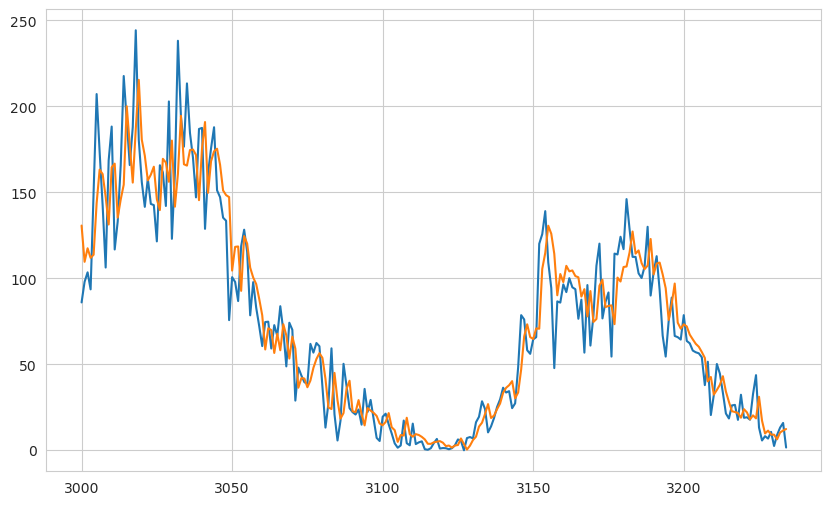

In [15]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MAE
print(metrics.mean_absolute_error(x_valid, results).numpy())

14.758017


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.

In [17]:
!rm *.csv